In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


In [20]:
df = pd.read_csv('estadisticas_fantasy.csv')
print(df)

             Nombre Posición        Equipo  Puntos  Media Puntos Relevo  \
0       Lewandowski       DL  FC Barcelona     146                 2.85   
1          Raphinha       DL  FC Barcelona     143                 3.23   
2      Lamine Yamal       DL  FC Barcelona     137                 3.58   
3      Vinícius Jr.       DL   Real Madrid     118                 3.08   
4            Mbappe       DL   Real Madrid     102                 2.82   
..              ...      ...           ...     ...                  ...   
585         Vallejo       DF   Real Madrid      -1                 0.00   
586          Adrián       PO    Real Betis      -2                 0.00   
587  Rodrigo Abajas       DF   Valencia CF      -2                 0.00   
588     Juan Carlos       PO        Girona      -3                 0.00   
589        R Chasco       DF    Valladolid      -3                 0.11   

     Puntos Relevo Precio Actual Precio Inicial  Media  Partidos  ...  \
0               37   127.3

Atributs a descartar -> nom, index, entrenadors.
Atributs a canviar de string a int -> posicio, equip (segons classificacio?)
Atributs a normaltzar -> preu? (treure €), minuts?

In [21]:
print("num_atributs: ", len(df.keys()))
nan_columns = df.columns[df.isna().sum()>0].tolist()
print("NaNs: ", nan_columns)
print("num nans", df.isna().sum().sum())
print("Describe\n", df.describe())
print("\n\ninfo:\n", df.info())
print("\n\nnunique:\n", df.nunique())

num_atributs:  30
NaNs:  []
num nans 0
Describe
            Puntos  Media Puntos Relevo  Puntos Relevo       Media    Partidos  \
count  590.000000           590.000000     590.000000  590.000000  590.000000   
mean    27.794915             0.893814       9.661017    2.543678    9.001695   
std     25.861069             0.795729       9.135669    2.227177    4.500330   
min     -3.000000             0.000000       0.000000   -0.330000    0.000000   
25%      7.250000             0.000000       0.000000    0.730000    7.000000   
50%     21.000000             0.750000       8.000000    2.180000   11.000000   
75%     46.000000             1.400000      15.000000    4.000000   13.000000   
max    146.000000             3.580000      43.000000   11.420000   13.000000   

           Minutos       Goles  Asistencias  Asistencias sin Gol  \
count   590.000000  590.000000   590.000000           590.000000   
mean    399.581356    0.479661     0.362712             0.603390   
std     353.88170

In [22]:
df.rename(columns={'Unnamed: 0': 'ID_jugador'}, inplace=True)
df['Precio Actual'] = df['Precio Actual'].str.replace('.','')
df['Precio Inicial'] = df['Precio Inicial'].str.replace('.','')
le = LabelEncoder()
df['Posición'] = le.fit_transform(df['Posición'])
print(df['Equipo'].unique())
df['Equipo'] = le.fit_transform(df['Equipo'])

['FC Barcelona' 'Real Madrid' 'Atlético de Madrid' 'Leganés'
 'Real Sociedad' 'Girona' 'Mallorca' 'Equipo desconocido' 'Real Betis'
 'Las Palmas' 'Athletic Club' 'Espanyol' 'Valladolid' 'Alavés'
 'Celta de Vigo' 'Rayo Vallecano' 'Osasuna' 'Villarreal CF' 'Valencia CF']


C:\Users\santi\AppData\Local\Temp\ipykernel_8372\1628414821.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Precio Actual'] = df['Precio Actual'].str.replace('.','')
C:\Users\santi\AppData\Local\Temp\ipykernel_8372\1628414821.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Precio Inicial'] = df['Precio Inicial'].str.replace('.','')


C:\Users\santi\AppData\Local\Temp\ipykernel_8372\1355772171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


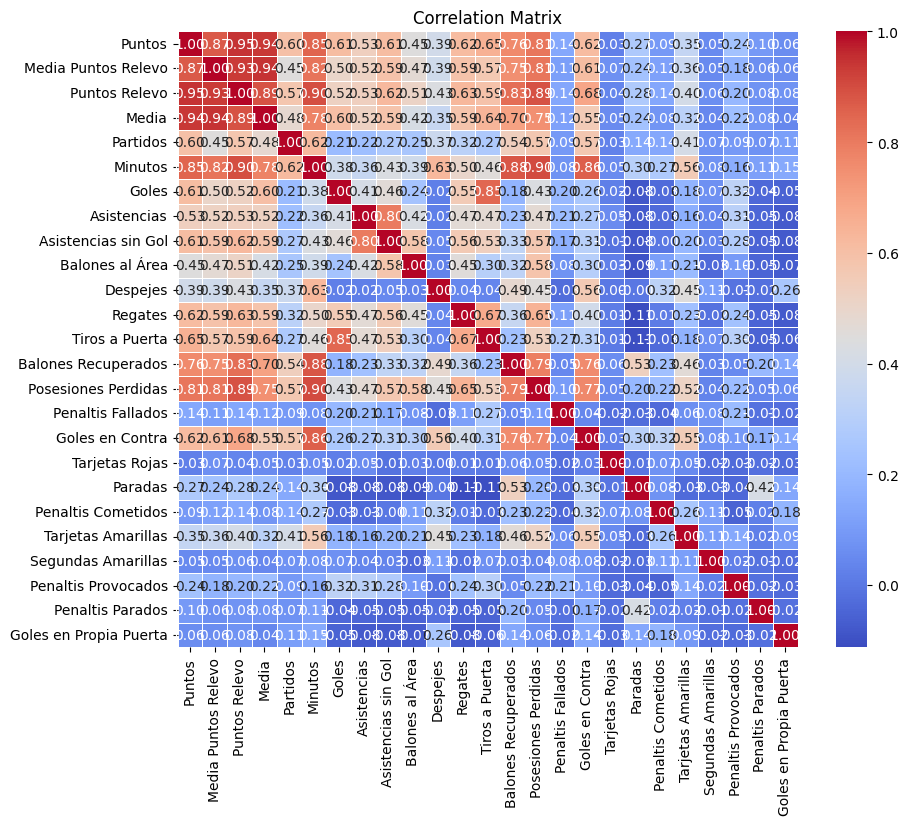

In [11]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()
